In [1]:
import pandas as pd

file_path = "/content/drive/MyDrive/CRYPTO/Preprocessed_data/data.csv"

data = pd.read_csv(file_path)


In [2]:
import pandas as pd
nan_values = data.isna().any().any()

if nan_values:
    print("There are NaN values in the DataFrame.")
else:
    print("There are no NaN values in the DataFrame.")

There are NaN values in the DataFrame.


Na początek wypełniamy brakujące wartości średnią wartości z danej kolumny

In [3]:
import pandas as pd

data_filled = data.fillna(data.mean())

In [4]:
DATA = data_filled.values

In [5]:
DATA[0][:5]

array([7.44683008e+03, 7.44683008e+03, 7.10152002e+03, 7.14358008e+03,
       2.05314000e+00])

Dzielimy dane na ramki.

Będziemy przewidywać 1 dzień na podstawie poprzedniego miesiącia czyli 1 ramka będzie zawierała dane z 30 dni, każdy dzień zawiera dane z poszczególnych kolumn



In [6]:
DATA.shape

(2344, 50)

In [7]:
def reshape_data_mlt(data, n_timesteps):
    n_samples, n_features = data.shape

    reshaped_data_X = np.zeros((n_samples - n_timesteps, n_timesteps, n_features))
    reshaped_data_y = np.zeros((n_samples - n_timesteps, n_features))

    for i in range(n_samples - n_timesteps):
        reshaped_data_X[i] = data[i:i+n_timesteps]
        reshaped_data_y[i] = data[i+n_timesteps]

    return reshaped_data_X, reshaped_data_y


In [8]:
n_timesteps=30
n_features=50

Zrobimy prosty model bez specjalnego przygotowania danych, użyjemy jedynie naszej funkcji do zmiany kształtu danych.

Sprawdzimy czy nie będzie żadnych nieoczekiwanych błędów.

In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout


# Reshape the data into windows
X, y = reshape_data_mlt(DATA, n_timesteps)

# Extract only the first element of each target (y) sample
y = y[:, 3]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)),
    Dense(1)  # Output only 1 value
])

# Compile the model with a lower learning rate
optimizer = Adam(lr=0.001)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

# Add a callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
callbacks = [reduce_lr]

# Train the model with callbacks
# history = model.fit(X, y, epochs=500, batch_size=32, validation_split=0.2, callbacks=callbacks)


In [10]:
# model.save("/content/drive/MyDrive/CRYPTO/Models/OVERALL_model.h5")

In [11]:
from tensorflow.keras.models import load_model

# Load the saved model
OVERALL_model = load_model("/content/drive/MyDrive/CRYPTO/Models/OVERALL_model.h5")

In [12]:
OVERALL_model.evaluate(X,y)

73/73 [==============================] - 2s 11ms/step - loss: 337231968.0000 - mae: 7044.8047


[337231968.0, 7044.8046875]

Model myli się o około 7-8 tysięcy. Biorąc pod uwagę że cena BTC zazwyczaj utrzymuje się między 10-60k. Oczywiście nie jest to model który można uznać za dobry ale teraz mamy pewność, że zarówna nasza funkcja jak i model działa bez żadnych błędów.

 Dzięki temu mamy również pogląd na czym stoimy, jakie wyniki jesteśmy w stanie uzyskać za pomocą najprostszej architektury i bez specjalnej regularyzacji.

Teraz dokładniej przeanalizujemy wpływ poszczególnych danych na wynik.

In [13]:
my_list = [str(i) for i in range(50)]
print(my_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']


In [14]:
del my_list[4]

Algorytm sprawdzający które kolumny mają największy wpływ na target

In [15]:
data_filled.shape

(2344, 50)

[48 44 13 47 45 12 46 14 19 22 20 23 18 15 11 21 28 36  9 16 17  4  8 10
  5  7 32  6 40 38 42 33 29  0 24 25 26 34 30 41  2  1 37 43 27 39 31 35
  3]


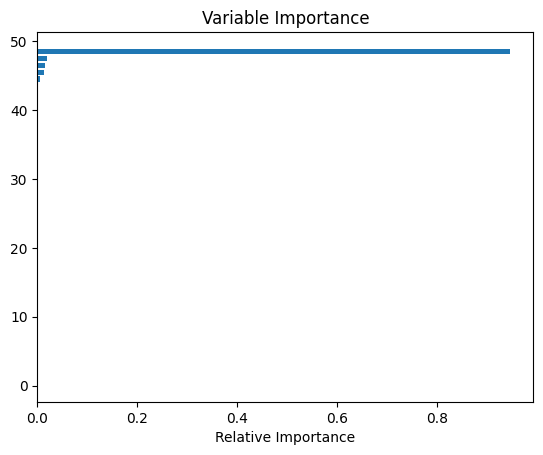

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Define features and target variable
features = my_list

df= data_filled
X = df[features]
y = df['3']

# Initialize and train the RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X, y)

# Plot feature importances
importances = regressor.feature_importances_
sorted_idx = np.argsort(importances)
print(sorted_idx)
padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
# plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()




In [17]:
sorted_idx=np.flip(sorted_idx)

In [18]:
len(sorted_idx)

49

In [19]:
List_of_data=["BTC_OPEN","BTC_HIGH","BTC_LOW","BTC_CLOSE","BNB_OPEN","BNB_HIGH","BNB_LOW","BNB_CLOSE","ETH_OPEN","ETH_HIGH","ETH_LOW","ETH_CLOSE","BCH_OPEN","BCH_HIGH","BCH_LOW","BCH_CLOSE","DOGE_OPEN","DOGE_HIGH","DOGE_LOW","DOGE_CLOSE","AVAX_OPEN","AVAX_HIGH","AVAX_LOW","AVAX_CLOSE","API_DATA","CAD_OPEN","CAD_HIGH","CAD_LOW","CAD_CLOSE","CNY_OPEN","CNY_HIGH","CNY_LOW","CNY_CLOSE","EUR_OPEN","EUR_HIGH","EUR_LOW","EUR_CLOSE","GBP_OPEN","GBP_HIGH","GBP_LOW","GBP_CLOSE","JPY_OPEN","JPY_HIGH","JPY_LOW","JPY_CLOSE","BTC_VOLUME","NYSE","NASDAQ","LSE","HALVING"]

In [20]:
for x in range(len(List_of_data)-1):
    print(List_of_data[sorted_idx[x]])

BTC_CLOSE
EUR_LOW
CNY_LOW
GBP_LOW
CAD_LOW
JPY_LOW
GBP_OPEN
BTC_HIGH
BTC_LOW
JPY_OPEN
CNY_HIGH
EUR_HIGH
CAD_HIGH
CAD_OPEN
API_DATA
BTC_OPEN
CNY_OPEN
EUR_OPEN
JPY_HIGH
GBP_HIGH
GBP_CLOSE
BNB_LOW
CNY_CLOSE
BNB_CLOSE
BNB_HIGH
ETH_LOW
ETH_OPEN
BNB_OPEN
DOGE_HIGH
DOGE_OPEN
ETH_HIGH
EUR_CLOSE
CAD_CLOSE
AVAX_HIGH
ETH_CLOSE
BCH_CLOSE
DOGE_LOW
AVAX_CLOSE
AVAX_OPEN
AVAX_LOW
DOGE_CLOSE
BCH_LOW
NYSE
BCH_OPEN
BTC_VOLUME
NASDAQ
BCH_HIGH
JPY_CLOSE
LSE


Mamy teraz pewien pogląd na to które dane mają duży wpływ na wynik. Oczywiście nie jest to ostateczny wyznacznik, jedynie zgodność korelacji, warto jednak przyjrzeć się temu dokładniej.

Waluty

Z analizy wynika że największa korelacja jest oczywiście z cenami w przeliczeniu na inne waluty. Nie mówi to koniecznie o tym że te właśnie dane polepszają jakość modelu. Wręcz przeciwnie, korelacja oznacza że dane są do siebie podobne, oznacza to że podawanie cen w porównaniu do innych walut może być tylko niepotrzebnym wprowadzaniem danych które ostatecznie nie dodają żadnych wartościowych informacji, jedynie je powielają. Możemy więc stwierdzić że powinniśmy traktować te listę w sposób odwrotny, dane z największą korelacją mogą być tymi które wprowadzają najmniej wartościowych informacji.

Nie powinniśmy ich całkime usuwać, jednak należałoby ograniczyć ich ilość, np. poprzez usunięcie Open,High,Low. Tak szczegółowa analiza samych walut sprawi tylko że model będzie działał wolniej i niekoniecznie lepiej



Aby sprawdzić realny wpływ na performance stworzymy kilka prostych modeli

1.BTC+co-currencies

2.BTC+API

3.BTC+waluty

4.BTC+Volume

5.BTC+Markets_value

*Halving traktujemy jako integralną częśc ceny BTC, jego wpływ jest zbyt oczywisty, ważny aby go rozważać

Na początek stworzymy jednak Base model, tylko na podstawie ceny BTC aby mieć punkt odniesienia

Zmodyfikujemy naszą funckję. Teraz będzie tworzyła ramki jedynie z kolumn których indeksy jej podamy.

In [21]:
import numpy as np

def reshape_data_mlt_feature_changer(data, n_timesteps, feature_indices):

    n_samples, n_features = data.shape

    reshaped_data_X = np.zeros((n_samples - n_timesteps, n_timesteps, len(feature_indices)))
    reshaped_data_y = np.zeros((n_samples - n_timesteps, 1))

    for i in range(n_samples - n_timesteps):
        selected_features_X = data[i:i+n_timesteps, feature_indices]
        selected_features_y = data[i+n_timesteps, 3]
        reshaped_data_X[i] = selected_features_X
        reshaped_data_y[i] = selected_features_y

    return reshaped_data_X, reshaped_data_y


Base model

In [22]:
base_features=[0,1,2,3,49]

Wprowadzamy MinMaxScaler, skalujemy wszystkie dane do wartości między 0 a 1.

In [23]:

import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]


DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])


reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,base_features)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)


base_model = Sequential()
base_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
base_model.add(Dropout(0.2))
base_model.add(LSTM(64, return_sequences=False))
base_model.add(Dense(1))

optimizer = Adam(lr=0.001)
base_model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

history = base_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

loss, mae, mse = base_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test MSE:", mse)


Epoch 1/50
47/47 [==============================] - 11s 93ms/step - loss: 0.0063 - mae: 0.0461 - mse: 0.0063 - val_loss: 0.0011 - val_mae: 0.0243 - val_mse: 0.0011
Epoch 2/50
47/47 [==============================] - 4s 95ms/step - loss: 0.0013 - mae: 0.0240 - mse: 0.0013 - val_loss: 0.0025 - val_mae: 0.0405 - val_mse: 0.0025
Epoch 3/50
47/47 [==============================] - 4s 77ms/step - loss: 0.0011 - mae: 0.0205 - mse: 0.0011 - val_loss: 0.0013 - val_mae: 0.0271 - val_mse: 0.0013
Epoch 4/50
47/47 [==============================] - 3s 65ms/step - loss: 0.0011 - mae: 0.0211 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0254 - val_mse: 0.0011
Epoch 5/50
47/47 [==============================] - 3s 67ms/step - loss: 8.8178e-04 - mae: 0.0196 - mse: 8.8178e-04 - val_loss: 0.0021 - val_mae: 0.0384 - val_mse: 0.0021
Epoch 6/50
47/47 [==============================] - 5s 98ms/step - loss: 9.6804e-04 - mae: 0.0212 - mse: 9.6804e-04 - val_loss: 0.0010 - val_mae: 0.0236 - val_mse: 0.0010
Epoch

In [24]:
zero_model_performance=[0,0,0]
zero_model_performance[0],zero_model_performance[1],zero_model_performance[2]=base_model.evaluate(X_test,y_test)

15/15 [==============================] - 1s 49ms/step - loss: 3.6914e-04 - mae: 0.0149 - mse: 3.6914e-04


In [25]:
y_scaler=scalers[3]

15/15 [==============================] - 1s 22ms/step


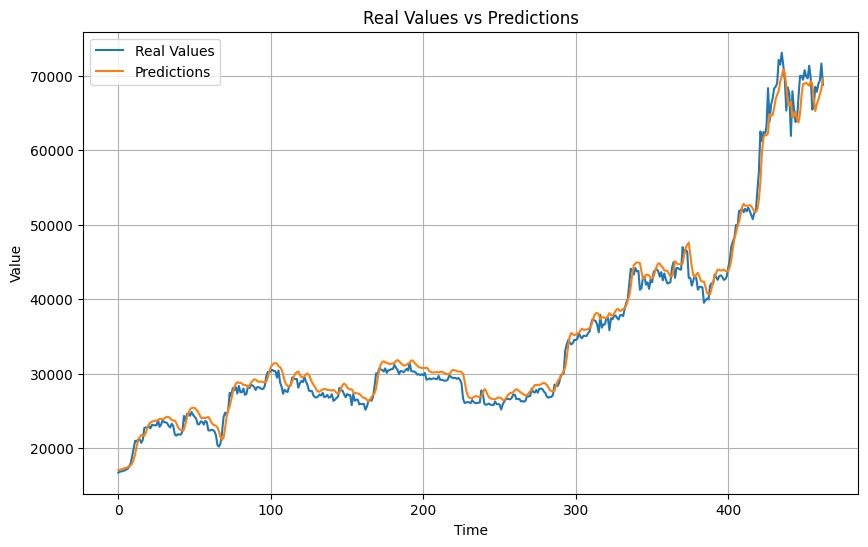

In [26]:
import matplotlib.pyplot as plt

predictions = base_model.predict(X_test)

predictions = y_scaler.inverse_transform(predictions)
real_y=y_scaler.inverse_transform(y_test)

# Plot the real values and predictions
plt.figure(figsize=(10, 6))
plt.plot(real_y, label='Real Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Real Values vs Predictions')
plt.legend()
plt.grid(True)
plt.show()


1.BTC + co-currencies

Najpierw Stworzymy model rozszerzony który zawiera Open,High,Low prices.

Potem model tylko na podstawie Close price.

Ocenimy czy takie dodatkowe cechy faktycznie pomagają w trenowaniu modelu czy tylko niepotrzebnie spowalniają model

In [27]:
co_currencies_extended_indexes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,49]

In [28]:
reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA,n_timesteps,co_currencies_extended_indexes)

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Assuming you have reshaped_data_X and reshaped_data_y from the previous function
#
scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]


DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])


reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,co_currencies_extended_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)
#
# Define the LSTM model
co_cur_ext_model = Sequential()
co_cur_ext_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
co_cur_ext_model.add(Dropout(0.2))
co_cur_ext_model.add(LSTM(64, return_sequences=False))
co_cur_ext_model.add(Dense(1))

# Compile the co_cur_ext_model
optimizer = Adam(lr=0.001)
co_cur_ext_model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

# Train the co_cur_ext_model
history = co_cur_ext_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the co_cur_ext_model on the testing data
loss, mae, mse = co_cur_ext_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test MSE:", mse)


Epoch 1/50
47/47 [==============================] - 10s 100ms/step - loss: 0.0059 - mae: 0.0465 - mse: 0.0059 - val_loss: 0.0190 - val_mae: 0.1313 - val_mse: 0.0190
Epoch 2/50
47/47 [==============================] - 3s 67ms/step - loss: 0.0013 - mae: 0.0236 - mse: 0.0013 - val_loss: 0.0130 - val_mae: 0.1074 - val_mse: 0.0130
Epoch 3/50
47/47 [==============================] - 5s 114ms/step - loss: 0.0012 - mae: 0.0228 - mse: 0.0012 - val_loss: 0.0048 - val_mae: 0.0618 - val_mse: 0.0048
Epoch 4/50
47/47 [==============================] - 4s 75ms/step - loss: 9.6321e-04 - mae: 0.0205 - mse: 9.6321e-04 - val_loss: 0.0092 - val_mae: 0.0907 - val_mse: 0.0092
Epoch 5/50
47/47 [==============================] - 3s 69ms/step - loss: 9.3587e-04 - mae: 0.0199 - mse: 9.3587e-04 - val_loss: 0.0026 - val_mae: 0.0440 - val_mse: 0.0026
Epoch 6/50
47/47 [==============================] - 3s 67ms/step - loss: 9.6130e-04 - mae: 0.0211 - mse: 9.6130e-04 - val_loss: 0.0084 - val_mae: 0.0868 - val_mse: 0.

In [30]:
co_cur_ext_model.evaluate(X_test,y_test)

15/15 [==============================] - 1s 38ms/step - loss: 0.0016 - mae: 0.0363 - mse: 0.0016


[0.001625190139748156, 0.0362958163022995, 0.001625190139748156]

In [31]:
co_currenceis_simplified_indexes=[0,1,2,3,7,11,15,19,23,49]

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Assuming you have reshaped_data_X and reshaped_data_y from the previous function

scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]


DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])


reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,co_currenceis_simplified_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

# Define the LSTM model
co_cur_simp_model = Sequential()
co_cur_simp_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
co_cur_simp_model.add(Dropout(0.2))
co_cur_simp_model.add(LSTM(64, return_sequences=False))
co_cur_simp_model.add(Dense(1))

# Compile the co_cur_simp_model
optimizer = Adam(lr=0.001)
co_cur_simp_model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

# Train the co_cur_simp_model
history = co_cur_simp_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the co_cur_simp_model on the testing data
loss, mae, mse = co_cur_simp_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test MSE:", mse)


Epoch 1/50
47/47 [==============================] - 9s 91ms/step - loss: 0.0486 - mae: 0.0486 - mse: 0.0066 - val_loss: 0.0617 - val_mae: 0.0617 - val_mse: 0.0046
Epoch 2/50
47/47 [==============================] - 3s 66ms/step - loss: 0.0224 - mae: 0.0224 - mse: 0.0014 - val_loss: 0.0390 - val_mae: 0.0390 - val_mse: 0.0020
Epoch 3/50
47/47 [==============================] - 5s 107ms/step - loss: 0.0192 - mae: 0.0192 - mse: 9.7528e-04 - val_loss: 0.0521 - val_mae: 0.0521 - val_mse: 0.0034
Epoch 4/50
47/47 [==============================] - 3s 63ms/step - loss: 0.0181 - mae: 0.0181 - mse: 8.8206e-04 - val_loss: 0.0487 - val_mae: 0.0487 - val_mse: 0.0030
Epoch 5/50
47/47 [==============================] - 3s 67ms/step - loss: 0.0172 - mae: 0.0172 - mse: 7.6312e-04 - val_loss: 0.0374 - val_mae: 0.0374 - val_mse: 0.0019
Epoch 6/50
47/47 [==============================] - 3s 64ms/step - loss: 0.0181 - mae: 0.0181 - mse: 8.1678e-04 - val_loss: 0.0460 - val_mae: 0.0460 - val_mse: 0.0027
Epoch

In [33]:
co_cur_simp_model.evaluate(X_test,y_test)

15/15 [==============================] - 0s 22ms/step - loss: 0.0306 - mae: 0.0306 - mse: 0.0011


[0.030599337071180344, 0.030599337071180344, 0.0011268524685874581]

Różnica między modelami nie jest duża.

Model uproszczony wydaje się sprawować nieco lepiej jednak może to wynikać z infrastruktury obu modeli. Mimo że model rozszerzony przyjmuje kilkukrotnie więcej danych, ma on tyle samo neuronów na obliczenia co model podstawowy.

Wyszkolenie go zajęło trochę dłużej niż wyszkolenie modelu podstawowego jednak nie jest to duża różnica

Nie zważając na niewielka różnice w wynikach, kolejne modele będziemy testować w wersji rozszerzonej. Kiedy rozbudujemy architekturę modelu, wtedy dane z wersji rozszerzonych powinny mieć większy wpływ na wynik.

In [34]:
loop_models_indexes=[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,49],[0,1,2,3,24,49],[0,1,2,3,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,49],[0,1,2,3,45,49],[0,1,2,3,46,47,48,49]]

In [35]:
loop_models_performance=np.empty((5,3))

In [36]:
for x in range(len(loop_models_indexes)):
    indexes=loop_models_indexes[x]

    scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

    DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

    reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,indexes)

    X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

    loop_model = Sequential()
    loop_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    loop_model.add(Dropout(0.2))
    loop_model.add(LSTM(64, return_sequences=False))
    loop_model.add(Dense(1))

    optimizer = Adam(lr=0.001)
    loop_model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

    history = loop_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,verbose=0)

    print(x)
    loss,mae,mse=loop_model.evaluate(X_test,y_test)

    loop_models_performance[x][0]=loss
    loop_models_performance[x][1]=mae
    loop_models_performance[x][2]=mse


0
15/15 [==============================] - 0s 27ms/step - loss: 0.0303 - mae: 0.0303 - mse: 0.0011


1
15/15 [==============================] - 0s 24ms/step - loss: 0.0203 - mae: 0.0203 - mse: 5.4877e-04


2
15/15 [==============================] - 0s 24ms/step - loss: 0.0389 - mae: 0.0389 - mse: 0.0021


3
15/15 [==============================] - 0s 21ms/step - loss: 0.0126 - mae: 0.0126 - mse: 4.4193e-04


4
15/15 [==============================] - 0s 22ms/step - loss: 0.0156 - mae: 0.0156 - mse: 3.7441e-04


Porównujemy MAE wszystkich modeli

In [37]:
print(f"Base model: {zero_model_performance[1]}")
print(f"BTC+co-currencies: {loop_models_performance[0][1]}")
print(f"BTC+API: {loop_models_performance[1][1]}")
print(f"BTC+world-currencies: {loop_models_performance[2][1]}")
print(f"BTC+Volume: {loop_models_performance[3][1]}")
print(f"BTC+Markets: {loop_models_performance[4][1]}")

Base model: 0.014907455071806908
BTC+co-currencies: 0.03027386963367462
BTC+API: 0.02028595469892025
BTC+world-currencies: 0.038922782987356186
BTC+Volume: 0.01261178683489561
BTC+Markets: 0.015608582645654678


Prawie wszystkie modele okazały się lepsze niż base model.
Jedynie modele przetwarzające znacznie większa ilość danych spisują się gorzej. Tak jak pisałem wcześniej, może to wynikać z architektury modelu a nie z danych.
Sprawdzimy to jeszcze raz podczas trenowania ostatecznego modelu, który będzie bardziej rozbudowany niż modele trenowane przez nas teraz.

Z modeli przetwarzającyh mniejszą ilość danych najlepiej spisał się BTC+Markets a najgorzej BTC+Volume. Mimo że model nie jest zły to warto się mu dokładniej przyjrzeć

Porównamy ilość NaN'ów w Volume oraz giełdach, model z giełdami spisał się dobrze mimo że duża część danych to NaN. Czy to znaczy że w Volume NaN'ów jest o wiele więcej?

In [39]:
import pandas as pd

count_nan_volume = data['45'].isna().sum()
count_nan_nyse= data['46'].isna().sum()
count_nan_nasdaq = data['47'].isna().sum()
count_nan_lse = data['48'].isna().sum()


print(f"Volume: {count_nan_volume}")
print(f"Nyse: {count_nan_nyse}")
print(f"Nasdaq: {count_nan_nasdaq}")
print(f"Lse: {count_nan_lse}")


Volume: 770
Nyse: 961
Nasdaq: 961
Lse: 961


Okazuje się że w Volume brakujących wartości jest MNIEJ niż w giełdach, skąd więc taka duża różnica w wynikach modelu?

Warto pamiętać że brakujące wartości zastąpiliśmy średnią wartością danych z danej kolumny, co oczywiście nie jest idealnym rozwiązaniem jednak w większości przypadków absolutnie wystarczającym

In [40]:
import pandas as pd

min_value = df['45'].min()
max_value = df['45'].max()

print("Min Volume value :", min_value)
print("Max Volume value :", max_value)

min_value = df['46'].min()
max_value = df['46'].max()

print("Min NYSE:", min_value)
print("Max NYSE:", max_value)

min_value = df['47'].min()
max_value = df['47'].max()

print("Min NASDAQ:", min_value)
print("Max NASDAQ:", max_value)

min_value = df['48'].min()
max_value = df['48'].max()

print("Min LSE:", min_value)
print("Max LSE:", max_value)




Min Volume value : 7326.81
Max Volume value : 1446125474.0765376
Min NYSE: 8777.3798828125
Max NYSE: 17353.759765625
Min NASDAQ: 6192.919921875
Max NASDAQ: 16057.4404296875
Min LSE: 3649.0
Max LSE: 9910.0


In [41]:
mean_value = df['45'].mean()

print("mean Volume value :", mean_value)

mean_value = df['46'].mean()

print("mean NYSE:", mean_value)

mean_value = df['47'].mean()

print("mean NASDAQ:", mean_value)

mean_value = df['48'].mean()

print("mean LSE:", mean_value)


mean Volume value : 102721105.78741343
mean NYSE: 14104.88804413526
mean NASDAQ: 10582.317238058116
mean LSE: 6849.880587166147


In [42]:
print(f"MIN wartość volume jest {int(1446125474.0765376/7326.81)} razy mniejsza niż MAX")

MIN wartość volume jest 197374 razy mniejsza niż MAX


In [43]:
print(f"MIN wartość NASDAQ jest {int(16057.4404296875/6192.919921875)} razy mniejsza niż MAX")

MIN wartość NASDAQ jest 2 raza mniejsza niż MAX


In [44]:
data_filled.shape

(2344, 50)

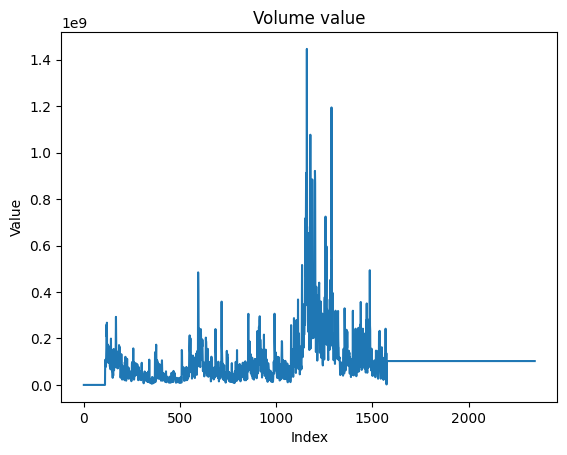

In [45]:
import matplotlib.pyplot as plt
plt.plot(data_filled['45'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Volume value')
plt.show()

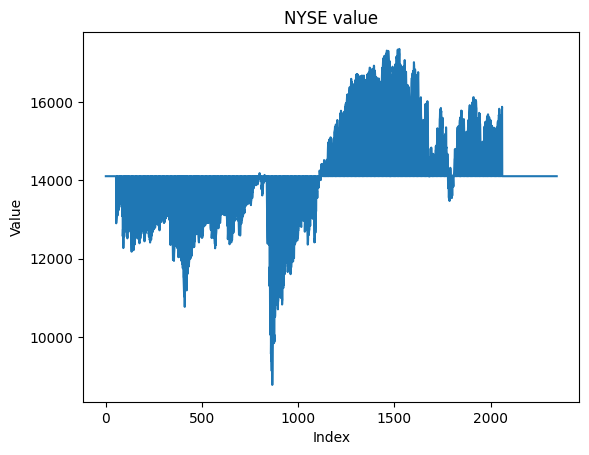

In [46]:
import matplotlib.pyplot as plt
plt.plot(data_filled['46'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('NYSE value')
plt.show()

Teraz dobrze widać gdzie jest problem.

W rozpatrywanym przez nas czasie Volume zwiększa się niemal 200 000 krotnie, podczas gdy wartość giełd 2-3 krotnie.

W przypadku giełd zastosowanie średniej wartości nie jest złym wyjściem gdyż nie zmienia się ona drastycznie na przestrzeni czasu.

W przypadku Volume sprawa jest inna, model wariuje kiedy widzi że w ciągu np. miesiąca wartość kilkukrotnie skacze od 20 tysięcy do np. 2 milionów a następnie na długi czas zatrzymuje się na jednej wartości

Musimy Zastąpić puste rekordy w inny sposób.

Zastąpienie sąsiednim rekordem w tym przypadku również nie zadziała, brakujące dane występują w dwóch długich seriach więc sytuacja będzię taka sama jak przy zaastąpieniu średnią wartością - duże wahania a nastepnie brak zmian.



Najlepsze efekty da nam zbudowanie prostego modelu który na podstawie znanej korelacji Volume oraz ceny BTC, uzupełni brakujące dane bazując na właśnie na zmianie ceny BTC.

Niestety znowu nie jest to rozwiązanie idealne, w tego typu przypadku jedynym idealnym rozwiązaniem jest posiadanie pełnych danych, jednak nie zawsze możemy na to liczyć. Istnieje możliwość że przewidując Volume na podstawie BTC, a następnie na odwrót, BTC na podstawie Volume, właściwie nie wprowadzimy żadnych nowych danych gdyż po wygenerowaniu takich danych będą one niejako tożsame.

Jednakże ze szkolenia modeli w pętli wynikło, że dawanie modelowi danych, niejako tożsamych np. cen różnych walut które ostatecznie i tak są odpowiednio przeliczane na USD, przynosi efekty i poprawia działanie modelu, jest on w stanie wyciągnąć z nich to co potrzebne.

Stowrzymy model do Volume a następnie sprawdzimy czy faktycznie, wygenerowane dane sprawią że model BTC+Volume będzie lepszy niż jego poprzednik



Zrobimy to jednak w oddzielnym pliku - CRYPTO_volume_model

Pobieramy uzupełnione dane Volume

In [47]:
Volume_df= pd.read_csv("/content/drive/MyDrive/CRYPTO/Preprocessed_data/Volume.csv")

In [48]:
Volume_data = Volume_df.to_numpy()

In [49]:
Volume_model_indicies=[0,1,2,3,4,5]

In [50]:
BTC_base_data=np.empty((2344,4))
vol_data=np.empty((2344,1))
halving_data=np.empty((2344,1))

Volume_model_full_data=np.empty((2344,6))
for x in range(2344):


    BTC_base_data[x][0]=DATA[x][0]
    BTC_base_data[x][1]=DATA[x][1]
    BTC_base_data[x][2]=DATA[x][2]
    BTC_base_data[x][3]=DATA[x][3]

    vol_data[x][0]=Volume_data[x]

    halving_data[x][0]=DATA[x][49]

<ipython-input-50-aaace3589f43>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vol_data[x][0]=Volume_data[x]


In [51]:
DATA.shape

(2344, 50)

In [52]:
base_scaler = MinMaxScaler()
halving_scaler = MinMaxScaler()
vol_scaler=MinMaxScaler()


BTC_base_data_scaled = base_scaler.fit_transform(BTC_base_data)
halving_data_scaled = halving_scaler.fit_transform(halving_data)
vol_data_scaled = vol_scaler.fit_transform(vol_data)

Volume_model_full_data=np.empty((2344,6))

for x in range(2344):
    Volume_model_full_data[x][0]=BTC_base_data_scaled[x][0]
    Volume_model_full_data[x][1]=BTC_base_data_scaled[x][1]
    Volume_model_full_data[x][2]=BTC_base_data_scaled[x][2]
    Volume_model_full_data[x][3]=BTC_base_data_scaled[x][3]
    Volume_model_full_data[x][4]=vol_data_scaled[x]
    Volume_model_full_data[x][5]=halving_data_scaled[x]


reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(Volume_model_full_data, n_timesteps, Volume_model_indicies)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(reshaped_data_y.reshape(-1, 1))
y_scaled = y_scaled.reshape(reshaped_data_y.shape)


X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, y_scaled, test_size=0.2, random_state=42)


# Define the LSTM model
volume_model = Sequential()
volume_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
volume_model.add(Dropout(0.2))
volume_model.add(LSTM(64, return_sequences=False))
volume_model.add(Dense(1))

# Compile the volume_model
optimizer = Adam(lr=0.001)
volume_model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

# Train the volume_model
history = volume_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

loss,mae,mse=volume_model.evaluate(X_test,y_test)

loop_models_performance[3][0]=loss
loop_models_performance[3][1]=mae
loop_models_performance[3][2]=mse

<ipython-input-52-51a3564b16f8>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Volume_model_full_data[x][4]=vol_data_scaled[x]
<ipython-input-52-51a3564b16f8>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Volume_model_full_data[x][5]=halving_data_scaled[x]


Epoch 1/50
47/47 [==============================] - 10s 99ms/step - loss: 0.0082 - mae: 0.0561 - mse: 0.0082 - val_loss: 0.0013 - val_mae: 0.0223 - val_mse: 0.0013
Epoch 2/50
47/47 [==============================] - 3s 71ms/step - loss: 0.0014 - mae: 0.0253 - mse: 0.0014 - val_loss: 0.0011 - val_mae: 0.0214 - val_mse: 0.0011
Epoch 3/50
47/47 [==============================] - 4s 94ms/step - loss: 0.0012 - mae: 0.0234 - mse: 0.0012 - val_loss: 0.0011 - val_mae: 0.0197 - val_mse: 0.0011
Epoch 4/50
47/47 [==============================] - 4s 83ms/step - loss: 0.0011 - mae: 0.0224 - mse: 0.0011 - val_loss: 9.3903e-04 - val_mae: 0.0192 - val_mse: 9.3903e-04
Epoch 5/50
47/47 [==============================] - 3s 70ms/step - loss: 0.0011 - mae: 0.0223 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0223 - val_mse: 0.0011
Epoch 6/50
47/47 [==============================] - 3s 69ms/step - loss: 0.0010 - mae: 0.0213 - mse: 0.0010 - val_loss: 8.5376e-04 - val_mae: 0.0177 - val_mse: 8.5376e-04
Epoch

In [53]:
print(f"Base model  -  loss:{zero_model_performance[0]},  mae:{zero_model_performance[1]},  mse:{zero_model_performance[2]}")
print(f"Volume model  -  loss:{loop_models_performance[3][0]},  mae:{loop_models_performance[3][1]},  mse:{loop_models_performance[3][2]}")

Base model  -  loss:0.0003691406163852662,  mae:0.014907455071806908,  mse:0.0003691406163852662
Volume model  -  loss:0.00049297307850793,  mae:0.014925513416528702,  mse:0.00049297307850793


Wyniki nie są znacząco lepsze. Musimy jednak brać pod uwagę pewien czynnik losowości. Kiedy trenujemy kilka razy ten sam model, zawsze dostaniemy lekko inne wyniki.

Podsumowując. Ustaliliśmy że wszystkie dane poprawiają wyniki modelu.

Teraz zostało nam tylko wyszkolić ostateczny model, który będzie trenowany na wszystkich dostępnych nam danych.



In [54]:
vol_data.shape

(2344, 1)

In [55]:
for x in range(len(DATA)):
    DATA[x][45]=vol_data[x][0]

In [56]:
DATA.shape

(2344, 50)

In [76]:
final_indexes=np.arange(0,50)

Co trzeba wytestować

BATCH_SIZE

n_timesteps

Nurony

Różne warstwy
    -BiDirectional(Raczej zawsze powinno być)
    -LSTM
    -CONV
    -GRU

Różne funckje aktywacyjne
    -Różne Liniowe
    -Jakieś nieliniowe

Loss value
    -mae
    -mse
DODATKI tzn:

DROPUT,
L-REgularization


Pomyśleć nad ensemble learning


Najpierw sprawdzimy jakie będzie najlepsze rozbudowanie modelu tzn. czy powinniśmy stworzyć prosty model z niewielką ilością neuronów czy jednak coś bardziej kompleksowego

Na początek prosty model Bidirectional LSTM + DENSE(relu)

Mała ilość neuronów



In [83]:
BATCH_SIZE = 32


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Use AUTOTUNE for optimization
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Define the LSTM model

zero_final_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)),
    LSTM(64, activation='relu', dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu'),
    Dense(1)  # Output only 1 value
])


# Compile the zero_final_model with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
zero_final_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

# Add a callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

# Train the zero_final_model with callbacks
history = zero_final_model.fit(train_dataset, epochs=500, batch_size=32, validation_data=test_dataset, callbacks=callbacks)


Epoch 1/500
58/58 [==============================] - 23s 289ms/step - loss: 1.2548 - mae: 0.0647 - val_loss: 0.5075 - val_mae: 0.2346 - lr: 0.0010
Epoch 2/500
58/58 [==============================] - 8s 141ms/step - loss: 0.2065 - mae: 0.0730 - val_loss: 0.1526 - val_mae: 0.2391 - lr: 0.0010
Epoch 3/500
58/58 [==============================] - 17s 290ms/step - loss: 0.0513 - mae: 0.0716 - val_loss: 0.1397 - val_mae: 0.2927 - lr: 0.0010
Epoch 4/500
58/58 [==============================] - 14s 249ms/step - loss: 0.0366 - mae: 0.0802 - val_loss: 0.1229 - val_mae: 0.2750 - lr: 0.0010
Epoch 5/500
58/58 [==============================] - 16s 270ms/step - loss: 0.0327 - mae: 0.0912 - val_loss: 0.1007 - val_mae: 0.2294 - lr: 0.0010
Epoch 6/500
58/58 [==============================] - 14s 243ms/step - loss: 0.0325 - mae: 0.0934 - val_loss: 0.0568 - val_mae: 0.1712 - lr: 0.0010
Epoch 7/500
58/58 [==============================] - 9s 147ms/step - loss: 0.0350 - mae: 0.1068 - val_loss: 0.0821 - va

In [84]:
zero_final_model.save("/content/drive/MyDrive/CRYPTO/Models/zero_final_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
zero_final_model_loaded=load_model("/content/drive/MyDrive/CRYPTO/Models/zero_final_model.h5")

In [86]:
zero_final_model_loaded.evaluate(X_test,y_test)

15/15 [==============================] - 2s 38ms/step - loss: 0.0037 - mae: 0.0469


[0.0037072766572237015, 0.04694398120045662]

Kolejny prosty model ale z dropoutem

In [87]:
BATCH_SIZE = 32


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Use AUTOTUNE for optimization
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Define the LSTM model

zero_dropout_final_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)),
    LSTM(64, activation='relu', dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Output only 1 value
])


# Compile the zero_dropout_final_model with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
zero_dropout_final_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

# Add a callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

# Train the zero_dropout_final_model with callbacks
history = zero_dropout_final_model.fit(train_dataset, epochs=500, batch_size=32, validation_data=test_dataset, callbacks=callbacks)


Epoch 1/500
58/58 [==============================] - 17s 138ms/step - loss: 1.2618 - mae: 0.1031 - val_loss: 0.5117 - val_mae: 0.2534 - lr: 0.0010
Epoch 2/500
58/58 [==============================] - 9s 159ms/step - loss: 0.2089 - mae: 0.0828 - val_loss: 0.1426 - val_mae: 0.2332 - lr: 0.0010
Epoch 3/500
58/58 [==============================] - 7s 122ms/step - loss: 0.0551 - mae: 0.0903 - val_loss: 0.0792 - val_mae: 0.1960 - lr: 0.0010
Epoch 4/500
58/58 [==============================] - 7s 121ms/step - loss: 0.0339 - mae: 0.0856 - val_loss: 0.0827 - val_mae: 0.2108 - lr: 0.0010
Epoch 5/500
58/58 [==============================] - 9s 156ms/step - loss: 0.0274 - mae: 0.0812 - val_loss: 0.1126 - val_mae: 0.2654 - lr: 0.0010
Epoch 6/500
58/58 [==============================] - 8s 137ms/step - loss: 0.0276 - mae: 0.0845 - val_loss: 0.0775 - val_mae: 0.2082 - lr: 0.0010
Epoch 7/500
58/58 [==============================] - 8s 140ms/step - loss: 0.0539 - mae: 0.1391 - val_loss: 0.0363 - val_ma

In [90]:
zero_dropout_final_model.save("/content/drive/MyDrive/CRYPTO/Models/zero_dropout_final_model.h5")

In [91]:
zero_dropout_final_model_loaded=load_model("/content/drive/MyDrive/CRYPTO/Models/zero_dropout_final_model.h5")

In [92]:
zero_dropout_final_model_loaded.evaluate(X_test,y_test)

15/15 [==============================] - 2s 73ms/step - loss: 0.0025 - mae: 0.0340


[0.0025142463855445385, 0.033994052559137344]

Troche więcej neuronów

In [94]:
BATCH_SIZE = 32


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Use AUTOTUNE for optimization
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Define the LSTM model
first_final_model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, kernel_regularizer=l2(0.01)),
                  input_shape=(n_timesteps, n_features)),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, kernel_regularizer=l2(0.01))),
    LSTM(64, activation='relu', dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True),
    LSTM(32, activation='relu', dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output only 1 value
])

# Compile the first_final_model with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
first_final_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

# Add a callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

# Train the first_final_model with callbacks
# history = first_final_model.fit(train_dataset, epochs=500, batch_size=32, validation_data=test_dataset, callbacks=callbacks)


In [63]:
# mae-0.0112
# val_mae-0.0432

In [64]:
# first_final_model.save("/content/drive/MyDrive/CRYPTO/Models/first_final_model.h5")

In [65]:
first_final_model_lodaed=load_model("/content/drive/MyDrive/CRYPTO/Models/first_final_model.h5")

In [95]:
first_final_model_lodaed.evaluate(X_test,y_test)

15/15 [==============================] - 8s 195ms/step - loss: 0.0595 - mae: 0.1621


[0.05950476601719856, 0.1620994210243225]

Wyniki na danych testowych są znacznie gorsze niż na danych treningowych.

Znowu powinniśmy dodać Droput

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Use AUTOTUNE for optimization
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Define the LSTM model
first_dropout_final_model = Sequential([
    Bidirectional(LSTM(512, return_sequences=True, dropout=0.2, kernel_regularizer=l2(0.01)),
                  input_shape=(n_timesteps, n_features)),
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, kernel_regularizer=l2(0.01))),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, kernel_regularizer=l2(0.01))),
    LSTM(64, activation='relu', dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True),
    LSTM(32, activation='relu', dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Output only 1 value
])


# Compile the first_dropout_final_model with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
first_dropout_final_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

# Add a callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

# Train the first_dropout_final_model with callbacks
# history = first_dropout_final_model.fit(train_dataset, epochs=500, batch_size=32, validation_data=test_dataset, callbacks=callbacks)


In [69]:
# first_dropout_final_model.save("/content/drive/MyDrive/CRYPTO/Models/first_dropout_final_model.h5")

In [98]:
first_dropout_final_model_lodaed=load_model("/content/drive/MyDrive/CRYPTO/Models/first_dropout_final_model.h5")

In [99]:
first_dropout_final_model_lodaed.evaluate(X_test,y_test)

15/15 [==============================] - 10s 497ms/step - loss: 0.0746 - mae: 0.2000


[0.07459024339914322, 0.20000162720680237]

Teraz wiadomo jak rozbudowany powinien byc model, zbyt skomplikowany zamiast dostrzegac nowe cechy będzie nauczy się tożsamości danych treningowych (overfitting)

Teraz budujemy model o podobnej kompleksowości co najlepiej sprawujący sie model.


Teraz powinniśmy sprawdzić jaki BATCH_SIZE będzie najefektywniejszy.

Duża liczba neuronów niestety nie pomogła z użytkowaniem danych z modeli rozszerzonych, w takim wypadku powinniśmy zrezygnować z używania tych danych

In [100]:
final_indexes=[0,1,2,3,7,11,15,19,23,24,28,32,36,40,44,45,46,47,48,49]

In [101]:
BATCH_SIZE = 32

scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)



small_batches_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)),
    LSTM(64, activation='relu', dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu'),
    Dense(1)
])


optimizer = Adam(learning_rate=0.001)
small_batches_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

history = small_batches_model.fit(train_dataset, epochs=500, batch_size=32, validation_data=test_dataset, callbacks=callbacks)


Epoch 1/500
58/58 [==============================] - 24s 174ms/step - loss: 1.2347 - mae: 0.0776 - val_loss: 0.4839 - val_mae: 0.2304 - lr: 0.0010
Epoch 2/500
58/58 [==============================] - 7s 117ms/step - loss: 0.2014 - mae: 0.0857 - val_loss: 0.0729 - val_mae: 0.0744 - lr: 0.0010
Epoch 3/500
58/58 [==============================] - 12s 205ms/step - loss: 0.0497 - mae: 0.0859 - val_loss: 0.0997 - val_mae: 0.2310 - lr: 0.0010
Epoch 4/500
58/58 [==============================] - 12s 206ms/step - loss: 0.0301 - mae: 0.0759 - val_loss: 0.1237 - val_mae: 0.2750 - lr: 0.0010
Epoch 5/500
58/58 [==============================] - 12s 201ms/step - loss: 0.0300 - mae: 0.0881 - val_loss: 0.0517 - val_mae: 0.1359 - lr: 0.0010
Epoch 6/500
58/58 [==============================] - 14s 249ms/step - loss: 0.0417 - mae: 0.1253 - val_loss: 0.0230 - val_mae: 0.0865 - lr: 0.0010
Epoch 7/500
58/58 [==============================] - 13s 228ms/step - loss: 0.0387 - mae: 0.1234 - val_loss: 0.0186 - v

In [102]:
small_batches_model.save("/content/drive/MyDrive/CRYPTO/Models/small_batches_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [103]:
small_batches_model_loaded=load_model("/content/drive/MyDrive/CRYPTO/Models/small_batches_model.h5")

In [111]:
small_batches_model_loaded.evaluate(X_test,y_test)

15/15 [==============================] - 4s 81ms/step - loss: 0.0027 - mae: 0.0302


[0.002733752829954028, 0.030241791158914566]

Zwiększamy BATCH_SIZE

In [104]:
BATCH_SIZE = 64

scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Use AUTOTUNE for optimization
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Define the LSTM model

medium_batches_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)),
    LSTM(64, activation='relu', dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu'),
    Dense(1)  # Output only 1 value
])


# Compile the medium_batches_model with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
medium_batches_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

# Add a callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

# Train the medium_batches_model with callbacks
history = medium_batches_model.fit(train_dataset, epochs=500, batch_size=64, validation_data=test_dataset, callbacks=callbacks)


Epoch 1/500
29/29 [==============================] - 15s 242ms/step - loss: 1.7695 - mae: 0.0763 - val_loss: 1.1406 - val_mae: 0.1802 - lr: 0.0010
Epoch 2/500
29/29 [==============================] - 5s 173ms/step - loss: 0.7468 - mae: 0.0893 - val_loss: 0.4791 - val_mae: 0.1454 - lr: 0.0010
Epoch 3/500
29/29 [==============================] - 7s 238ms/step - loss: 0.3296 - mae: 0.1266 - val_loss: 0.1947 - val_mae: 0.0800 - lr: 0.0010
Epoch 4/500
29/29 [==============================] - 5s 179ms/step - loss: 0.1654 - mae: 0.1177 - val_loss: 0.1377 - val_mae: 0.2176 - lr: 0.0010
Epoch 5/500
29/29 [==============================] - 7s 236ms/step - loss: 0.0706 - mae: 0.0486 - val_loss: 0.0503 - val_mae: 0.0252 - lr: 0.0010
Epoch 6/500
29/29 [==============================] - 5s 162ms/step - loss: 0.0430 - mae: 0.0451 - val_loss: 0.0333 - val_mae: 0.0368 - lr: 0.0010
Epoch 7/500
29/29 [==============================] - 7s 253ms/step - loss: 0.0343 - mae: 0.0636 - val_loss: 0.0473 - val_ma

In [105]:
medium_batches_model.save("/content/drive/MyDrive/CRYPTO/Models/medium_batches_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [106]:
medium_batches_model_loaded=load_model("/content/drive/MyDrive/CRYPTO/Models/medium_batches_model.h5")

In [112]:
medium_batches_model_loaded.evaluate(X_test,y_test)

15/15 [==============================] - 4s 91ms/step - loss: 0.0028 - mae: 0.0367


[0.0027533189859241247, 0.03671141713857651]

Znowu zwiększamy BATCH_SIZE

In [107]:
BATCH_SIZE = 128

scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Use AUTOTUNE for optimization
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Define the LSTM model

big_batches_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)),
    LSTM(64, activation='relu', dropout=0.2, kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu'),
    Dense(1)  # Output only 1 value
])


# Compile the big_batches_model with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
big_batches_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

# Add a callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

# Train the big_batches_model with callbacks
history = big_batches_model.fit(train_dataset, epochs=500, batch_size=128, validation_data=test_dataset, callbacks=callbacks)


Epoch 1/500
15/15 [==============================] - 13s 327ms/step - loss: 2.1777 - mae: 0.1430 - val_loss: 1.7242 - val_mae: 0.1918 - lr: 0.0010
Epoch 2/500
15/15 [==============================] - 5s 331ms/step - loss: 1.4219 - mae: 0.1194 - val_loss: 1.1851 - val_mae: 0.2663 - lr: 0.0010
Epoch 3/500
15/15 [==============================] - 4s 271ms/step - loss: 0.9309 - mae: 0.0973 - val_loss: 0.7542 - val_mae: 0.2184 - lr: 0.0010
Epoch 4/500
15/15 [==============================] - 4s 241ms/step - loss: 0.6112 - mae: 0.1229 - val_loss: 0.4650 - val_mae: 0.1076 - lr: 0.0010
Epoch 5/500
15/15 [==============================] - 6s 389ms/step - loss: 0.3999 - mae: 0.1131 - val_loss: 0.3896 - val_mae: 0.2800 - lr: 0.0010
Epoch 6/500
15/15 [==============================] - 4s 241ms/step - loss: 0.3074 - mae: 0.1764 - val_loss: 0.2325 - val_mae: 0.1300 - lr: 0.0010
Epoch 7/500
15/15 [==============================] - 4s 249ms/step - loss: 0.1800 - mae: 0.0659 - val_loss: 0.1484 - val_ma

In [108]:
big_batches_model.save("/content/drive/MyDrive/CRYPTO/Models/big_batches_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [109]:
big_batches_model_loaded=load_model("/content/drive/MyDrive/CRYPTO/Models/big_batches_model.h5")

In [113]:
big_batches_model_loaded.evaluate(X_test,y_test)

15/15 [==============================] - 6s 73ms/step - loss: 0.0036 - mae: 0.0423


[0.0035809408873319626, 0.04231996461749077]

BATCH_SIZE=32 jest najlepszym rozwiązaniem

Spróbujemy zastąpić Bidirectional LSTM na zwykł LSTM

In [114]:
scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)



LSTM_model = Sequential()
LSTM_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(64, return_sequences=False))
LSTM_model.add(Dense(1))


# Compile the big_batches_model with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
LSTM_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

# Add a callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

# Train the big_batches_model with callbacks
history = LSTM_model.fit(train_dataset, epochs=500, batch_size=128, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/500
15/15 [==============================] - 13s 277ms/step - loss: 0.0214 - mae: 0.1244 - val_loss: 0.0104 - val_mae: 0.0603 - lr: 0.0010
Epoch 2/500
15/15 [==============================] - 3s 212ms/step - loss: 0.0483 - mae: 0.1493 - val_loss: 0.0931 - val_mae: 0.3017 - lr: 0.0010
Epoch 3/500
15/15 [==============================] - 2s 152ms/step - loss: 0.0217 - mae: 0.1109 - val_loss: 0.0065 - val_mae: 0.0743 - lr: 0.0010
Epoch 4/500
15/15 [==============================] - 2s 163ms/step - loss: 0.0297 - mae: 0.1437 - val_loss: 0.0439 - val_mae: 0.1820 - lr: 0.0010
Epoch 5/500
15/15 [==============================] - 2s 152ms/step - loss: 0.0614 - mae: 0.1561 - val_loss: 0.0169 - val_mae: 0.0817 - lr: 0.0010
Epoch 6/500
15/15 [==============================] - 4s 275ms/step - loss: 0.0107 - mae: 0.0944 - val_loss: 0.0045 - val_mae: 0.0506 - lr: 0.0010
Epoch 7/500
15/15 [==============================] - 2s 149ms/step - loss: 0.0023 - mae: 0.0338 - val_loss: 0.0032 - val_ma

In [117]:
LSTM_model.save("/content/drive/MyDrive/CRYPTO/Models/LSTM_batches_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [118]:
LSTM_model_loaded=load_model("/content/drive/MyDrive/CRYPTO/Models/LSTM_batches_model.h5")

In [120]:
LSTM_model_loaded.evaluate(X_test,y_test)

15/15 [==============================] - 3s 40ms/step - loss: 0.0015 - mae: 0.0244


[0.0015461184084415436, 0.024416744709014893]

Zwykły LSTM radzi sobie lepiej

Możemy sprawdzić jeszcze warstwę GRU, tak samo jak LSTM jest to warstwa przeznaczona do przewidywania sekwencji.

In [125]:
from tensorflow.keras.layers import GRU
scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)



GRU_model = Sequential()
GRU_model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
GRU_model.add(Dropout(0.2))
GRU_model.add(GRU(64, return_sequences=False))
GRU_model.add(Dense(1))


optimizer = Adam(learning_rate=0.001)
GRU_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

history = GRU_model.fit(train_dataset, epochs=500, batch_size=128, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/500
15/15 [==============================] - 11s 229ms/step - loss: 0.0167 - mae: 0.1075 - val_loss: 0.0077 - val_mae: 0.0553 - lr: 0.0010
Epoch 2/500
15/15 [==============================] - 3s 222ms/step - loss: 0.0386 - mae: 0.1399 - val_loss: 0.2419 - val_mae: 0.4863 - lr: 0.0010
Epoch 3/500
15/15 [==============================] - 2s 135ms/step - loss: 0.0501 - mae: 0.1634 - val_loss: 0.0087 - val_mae: 0.0838 - lr: 0.0010
Epoch 4/500
15/15 [==============================] - 2s 141ms/step - loss: 0.0673 - mae: 0.2241 - val_loss: 0.0358 - val_mae: 0.1603 - lr: 0.0010
Epoch 5/500
15/15 [==============================] - 2s 131ms/step - loss: 0.0927 - mae: 0.2049 - val_loss: 0.0061 - val_mae: 0.0526 - lr: 0.0010
Epoch 6/500
15/15 [==============================] - 4s 297ms/step - loss: 0.0155 - mae: 0.1118 - val_loss: 0.0047 - val_mae: 0.0515 - lr: 0.0010
Epoch 7/500
15/15 [==============================] - 2s 126ms/step - loss: 0.0146 - mae: 0.1026 - val_loss: 0.0044 - val_ma

In [126]:
GRU_model.evaluate(X_test,y_test)

15/15 [==============================] - 3s 33ms/step - loss: 7.4660e-04 - mae: 0.0211


[0.000746600388083607, 0.02106551267206669]

In [130]:
GRU_model.save("/content/drive/MyDrive/CRYPTO/Models/GRU_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [131]:
GRU_model_loaded=load_model("/content/drive/MyDrive/CRYPTO/Models/GRU_model.h5")

Model GRU sprawuje się lepiej niż LSTM

Podstawowa funkcja aktywacyjna to tanh, funkcja nieliniowa

Sprawdzimy jeszcze funkcję relu oraz sigmoid

In [129]:
scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)



GRU_relu_model = Sequential()
GRU_relu_model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,activation="relu"))
GRU_relu_model.add(Dropout(0.2))
GRU_relu_model.add(GRU(64, return_sequences=False,activation="relu"))
GRU_relu_model.add(Dense(1))


optimizer = Adam(learning_rate=0.001)
GRU_relu_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

history = GRU_relu_model.fit(train_dataset, epochs=500, batch_size=128, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/500
15/15 [==============================] - 7s 170ms/step - loss: 0.0288 - mae: 0.1175 - val_loss: 0.0191 - val_mae: 0.1294 - lr: 0.0010
Epoch 2/500
15/15 [==============================] - 2s 124ms/step - loss: 0.0188 - mae: 0.1148 - val_loss: 0.0363 - val_mae: 0.1780 - lr: 0.0010
Epoch 3/500
15/15 [==============================] - 2s 136ms/step - loss: 0.0536 - mae: 0.2035 - val_loss: 0.0108 - val_mae: 0.0715 - lr: 0.0010
Epoch 4/500
15/15 [==============================] - 2s 149ms/step - loss: 0.0074 - mae: 0.0775 - val_loss: 0.0035 - val_mae: 0.0480 - lr: 0.0010
Epoch 5/500
15/15 [==============================] - 4s 275ms/step - loss: 0.0055 - mae: 0.0554 - val_loss: 0.0029 - val_mae: 0.0368 - lr: 0.0010
Epoch 6/500
15/15 [==============================] - 4s 246ms/step - loss: 0.0026 - mae: 0.0385 - val_loss: 0.0018 - val_mae: 0.0312 - lr: 0.0010
Epoch 7/500
15/15 [==============================] - 3s 219ms/step - loss: 0.0027 - mae: 0.0338 - val_loss: 0.0015 - val_mae

In [132]:
GRU_relu_model.evaluate(X_test,y_test)

15/15 [==============================] - 1s 24ms/step - loss: 0.0011 - mae: 0.0269


[0.0010715718381106853, 0.026895053684711456]

In [135]:
GRU_relu_model.save("/content/drive/MyDrive/CRYPTO/Models/GRU_relu_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [136]:
GRU_relu_model_loaded=load_model("/content/drive/MyDrive/CRYPTO/Models/GRU_relu_model.h5")

In [133]:
from tensorflow.keras.layers import GRU
scalers = [MinMaxScaler() for _ in range(DATA.shape[1])]

DATA_scaled = np.hstack([scaler.fit_transform(DATA[:, [i]]) for i, scaler in enumerate(scalers)])

reshaped_data_X, reshaped_data_y=reshape_data_mlt_feature_changer(DATA_scaled,n_timesteps,final_indexes)

X_train, X_test, y_train, y_test = train_test_split(reshaped_data_X, reshaped_data_y, test_size=0.2, random_state=42,shuffle=False)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)



GRU_sigmoid_model = Sequential()
GRU_sigmoid_model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,activation="sigmoid"))
GRU_sigmoid_model.add(Dropout(0.2))
GRU_sigmoid_model.add(GRU(64, return_sequences=False,activation="sigmoid"))
GRU_sigmoid_model.add(Dense(1))


optimizer = Adam(learning_rate=0.001)
GRU_sigmoid_model.compile(optimizer=optimizer, loss='mse',metrics=["mae"])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
callbacks = [reduce_lr,early_stopping]

history = GRU_sigmoid_model.fit(train_dataset, epochs=500, batch_size=128, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/500
15/15 [==============================] - 13s 459ms/step - loss: 0.0895 - mae: 0.2554 - val_loss: 0.0342 - val_mae: 0.1576 - lr: 0.0010
Epoch 2/500
15/15 [==============================] - 3s 208ms/step - loss: 0.1494 - mae: 0.3120 - val_loss: 0.0296 - val_mae: 0.1252 - lr: 0.0010
Epoch 3/500
15/15 [==============================] - 4s 279ms/step - loss: 0.1087 - mae: 0.2953 - val_loss: 0.0484 - val_mae: 0.1535 - lr: 0.0010
Epoch 4/500
15/15 [==============================] - 3s 218ms/step - loss: 0.0568 - mae: 0.1921 - val_loss: 0.0251 - val_mae: 0.1097 - lr: 0.0010
Epoch 5/500
15/15 [==============================] - 2s 126ms/step - loss: 0.0682 - mae: 0.2224 - val_loss: 0.0274 - val_mae: 0.1034 - lr: 0.0010
Epoch 6/500
15/15 [==============================] - 2s 138ms/step - loss: 0.0465 - mae: 0.1825 - val_loss: 0.0204 - val_mae: 0.0943 - lr: 0.0010
Epoch 7/500
15/15 [==============================] - 3s 211ms/step - loss: 0.0399 - mae: 0.1667 - val_loss: 0.0164 - val_ma

In [134]:
GRU_sigmoid_model.evaluate(X_test,y_test)

15/15 [==============================] - 1s 24ms/step - loss: 9.9468e-04 - mae: 0.0233


[0.0009946845239028335, 0.023342275992035866]

In [137]:
GRU_sigmoid_model.save("/content/drive/MyDrive/CRYPTO/Models/GRU_sigmoid_model.h5")

In [138]:
GRU_sigmoid_model_loaded=load_model("/content/drive/MyDrive/CRYPTO/Models/GRU_sigmoid_model.h5")

Model z warstwami GRU z bazową aktywacją tanh osiąga najlepsze wyniki.

Dane są na tyle nieskomplikowane, że jakiekolwiek rozszerzenie modelu tylko go pogarsza.

Wprowadzanie i testowanie kolejnych warstw nie przyniesie żadncyh efektów.

GRU_model jest na tyle prosty że nie możemy już nic więcej z nim zrobić.

Możemy uznać ten model za nasz model ostateczny.





Na koniec trzeba jeszcze zwrócić uwagę na jedną rzecz. Nasz ostateczny model ma gorsze wyniki niż jeszcze prostsze modele które trenowaliśmy wcześniej (modele z pętli), na których sprawdzaliśmy wpływ poszczególnych danych.

Czy to oznacza, że nasz ostateczny model jest gorszy od pierwszego lepszego modelu?

I tak i nie.

Prosty model sekwencyjny przewiduje na podstawie zmian w cenie które zaobserwował w przeszłości i nic poza tym. Na pierwszy rzut oka widać, że jest to bardzo naiwne. Ceny rynkowe są zależne od tysięcy różnych czynników, prosty model, który tego nie rozumie, przestanie być wairygodny kiedy tylko wydarzy się coś co ma wpływ na cenę a co nie wystąpiło w przeszłości. Model który nauczył się patternów spadków i wzrostów cen nie będzie miał możliwości prawidłowo zareagować w takiej sytuacji.

Model który stworzyliśmy jest w stanie zareagować na tego typu sytuacje znacznie lepiej. Używa on danych z wielu różnych źródeł, które na swój sposób obrazują działanie rynku, walut i innych coinów. Dzięki dywersyfikacji danych model ma znacznie większą odporność na niespodziewane wydarzenia na rynku.

Mimo iż jego MAE jest gorsze o niecały 1% od prostego modelu. Jest on znacznie bezpieczniejszym produktem np. dla kogoś kto chce inwestować część swoich oszczędności. Nie będzie on dokładny co do złotówki(chociaż w naszym przypadku to co do USD), ale będzie znacznie stabilniejszy i odporniejszy na różnego rodzaju rynkowe zawirowania.



In [141]:
train_predictions=GRU_model.predict(X_train)

58/58 [==============================] - 2s 28ms/step


In [142]:
test_predictions=GRU_model.predict(X_test)

15/15 [==============================] - 0s 29ms/step


In [144]:
final_predictions=np.append(train_predictions,test_predictions)

In [147]:
final_predictions = scalers[3].inverse_transform(final_predictions.reshape(-1, 1))

In [143]:
final_y=np.append(y_train,y_test)

In [148]:
final_y=scalers[3].inverse_transform(final_y.reshape(-1, 1))

Nasz model miał MAE(mean absolute error) na poziomie 0.02.

Używaliśmy MinMaxScaler co oznacza  że nasz model przewiduje cenę średnio o 2% większą lub mniejszą od ceny prawdziwej.

Najprościej będzie to zwizualizować

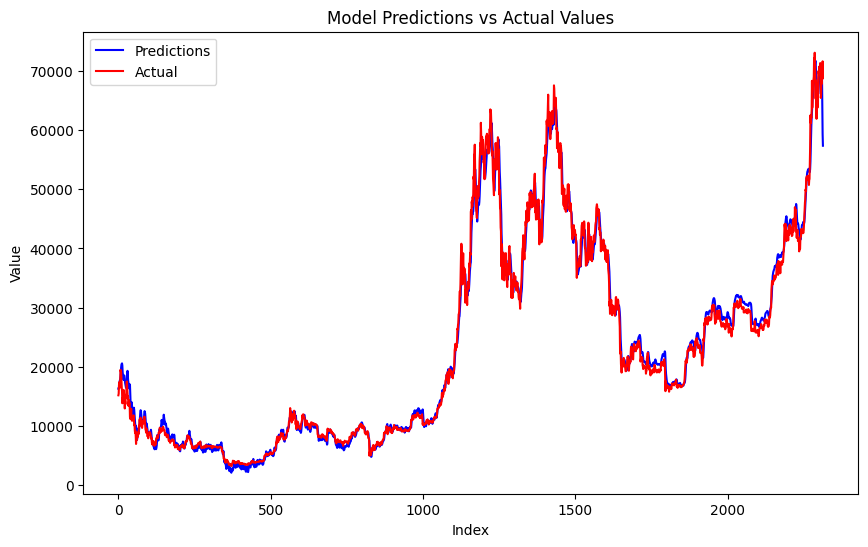

In [149]:
plt.figure(figsize=(10, 6))
plt.plot(final_predictions, label='Predictions', color='blue')
plt.plot(final_y, label='Real', color='red')
plt.title('Real values VS Predictions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

